In [29]:
%matplotlib inline

Neural Networks
===============

Neural networks can be constructed using the `torch.nn` package.

Now that you had a glimpse of `autograd`, `nn` depends on `autograd` to
define models and differentiate them. An `nn.Module` contains layers,
and a method `forward(input)` that returns the `output`.

For example, look at this network that classifies digit images:

![convnet](https://pytorch.org/tutorials/_static/img/mnist.png)

It is a simple feed-forward network. It takes the input, feeds it
through several layers one after the other, and then finally gives the
output.

A typical training procedure for a neural network is as follows:

-   Define the neural network that has some learnable parameters (or
    weights)
-   Iterate over a dataset of inputs
-   Process input through the network
-   Compute the loss (how far is the output from being correct)
-   Propagate gradients back into the network's parameters
-   Update the weights of the network, typically using a simple update
    rule: `weight = weight - learning_rate * gradient`

Definir la red
------------------

Let's define this network:


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 4*4 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # operaciones
    def forward(self, input):
        # Convolution layer C1: 1 input image channel, 6 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
        c1 = F.relu(self.conv1(input))
        # Subsampling layer S2: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
        s2 = F.max_pool2d(c1, (2, 2))
        # Convolution layer C3: 6 input channels, 16 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a (N, 16, 10, 10) Tensor
        c3 = F.relu(self.conv2(s2))
        # Subsampling layer S4: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
        s4 = F.max_pool2d(c3, 2)
        # Flatten operation: purely functional, outputs a (N, 400) Tensor
        s4 = torch.flatten(s4, 1)
        # Fully connected layer F5: (N, 400) Tensor input,
        # and outputs a (N, 120) Tensor, it uses RELU activation function
        f5 = F.relu(self.fc1(s4))
        # Fully connected layer F6: (N, 120) Tensor input,
        # and outputs a (N, 84) Tensor, it uses RELU activation function
        f6 = F.relu(self.fc2(f5))
        # Gaussian layer OUTPUT: (N, 84) Tensor input, and
        # outputs a (N, 10) Tensor
        output = self.fc3(f6)
        return output


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Cargar dataset

In [31]:
# cargar dataset
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 64
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)
# crear variables para datos de entrenamiento y pruebas
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
print(training_data)
print(test_data)
clases=training_data.classes
print(clases)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Obtener caractertisticas y etiquetas de las imágenes

In [32]:
#obtener caracteristicas de imagenes y etiquetas
train_features, train_labels = next(iter(train_dataloader))
print(f"Tamaño de batch, dimensiones y canales: {train_features.size()}")
print(f"Número de etiquetas por cada batch: {train_labels.size()}")

Tamaño de batch, dimensiones y canales: torch.Size([64, 1, 28, 28])
Número de etiquetas por cada batch: torch.Size([64])


### Definir función de perdida y optimizador

In [33]:
import torch.optim as optim

criterio = nn.CrossEntropyLoss()
# momentum sirve para acelerar el proceso de encontrar el valor más cercano a cero
optimizador = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Configurar uso de GPU

In [34]:
# elección de arquitectura
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Usando:",device)

# Mover el modelo a GPU/CPU
net.to(device)

Usando: cpu


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Entrenamiento del modelo de CNN

In [35]:
# Entrenamiento de modelo
mejor_modelo = None
mejor_perdida = float("inf")
m_epoca = 0
train_perdida = []
train_precision = []

for epoca in range(10):  # número de épocas

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the entradas; data is a list of [entradas, etiquetas]
        entradas, etiquetas = data
        # mover datos a GPU/CPU
        entradas, etiquetas = entradas.to(device), etiquetas.to(device)
        # gradiente de ceros
        optimizador.zero_grad()

        # forward + backward + optimize
        salidas = net(entradas) # envío
        perdida = criterio(salidas, etiquetas) # calculo diferencia o pérdida
        perdida.backward() # Actualiza pesos
        optimizador.step() # optimizo

        # print statistics
        running_loss += perdida.item() # perdida acumulada
    perdida_promedio = running_loss / len(train_dataloader)
    print(f"Epoca {epoca+1}, perdida promedio: {perdida_promedio:.3f}")
    # obtener mejor modelo
    if perdida_promedio < mejor_perdida:    # print every 15000 mini-batches
        m_perdida = perdida_promedio
        m_epoca = epoca+1
        mejor_modelo = net.state_dict()
    # almacenar perdidas en
    train_perdida.append(perdida_promedio)

    # Calcular accuracy en entrenamiento
    correcto = 0
    total = 0
    with torch.no_grad():
      for data in train_dataloader:
        entradas, etiquetas = data
        entradas, etiquetas = entradas.to(device), etiquetas.to(device)
        salidas = net(entradas)
        _, pred = torch.max(salidas, 1)
        total += etiquetas.size(0)
        correcto += (pred == etiquetas).sum().item()
    train_acc = 100 * correcto / total
    train_precision.append(train_acc)
print('='*60)
print(f"Modelo con menor perdida: {m_perdida:0.3f}, Epoca {m_epoca}")
print('Entrenamiento finalizado')

Epoca 1, perdida promedio: 1.679
Epoca 2, perdida promedio: 0.688
Epoca 3, perdida promedio: 0.582
Epoca 4, perdida promedio: 0.523
Epoca 5, perdida promedio: 0.481
Epoca 6, perdida promedio: 0.452
Epoca 7, perdida promedio: 0.425
Epoca 8, perdida promedio: 0.405
Epoca 9, perdida promedio: 0.387
Epoca 10, perdida promedio: 0.373
Modelo con menor perdida: 0.373, Epoca 10
Entrenamiento finalizado


### Guardar mejor modelo

In [36]:
ruta = './best_model.pth'
torch.save(mejor_modelo, ruta)

### Cargar modelo entrenado

In [37]:
net = Net()
net.load_state_dict(torch.load(ruta, weights_only=True))

<All keys matched successfully>

### Probar modelo

In [38]:
# Prueba de modelo por cada clase
correct_pred = {classname: 0 for classname in clases}
total_pred = {classname: 0 for classname in clases}

# no se necesita la gradiente ya que se entrena una sola vez
with torch.no_grad():
    for data in test_dataloader:
        imagenes, etiquetas = data
        salidas = net(imagenes)
        _, predicciones = torch.max(salidas, 1)
        # collección de predicciones correctas por cada clase
        for etiqueta, prediccion in zip(etiquetas, predicciones):
            if etiqueta == prediccion:
                correct_pred[clases[etiqueta]] += 1
            total_pred[clases[etiqueta]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy por clase: {classname:5s} es {accuracy:.2f} %')

Accuracy por clase: T-shirt/top es 72.90 %
Accuracy por clase: Trouser es 96.10 %
Accuracy por clase: Pullover es 76.30 %
Accuracy por clase: Dress es 86.40 %
Accuracy por clase: Coat  es 83.70 %
Accuracy por clase: Sandal es 95.00 %
Accuracy por clase: Shirt es 62.80 %
Accuracy por clase: Sneaker es 92.90 %
Accuracy por clase: Bag   es 96.00 %
Accuracy por clase: Ankle boot es 95.80 %


### Precisión total

In [39]:
# calcular pérdida y precisión en test
correcto = 0
total = 0
# no se necesita la gradiente
with torch.no_grad():
    for data in test_dataloader:
        entradas, etiquetas = data
        entradas, etiquetas = entradas.to(device), etiquetas.to(device)
        # calculate outputs by running images through the network
        salidas = net(entradas)
        # the class with the highest energy is what we choose as prediction
        _, prediccion = torch.max(salidas, 1)
        total += etiquetas.size(0)
        correcto += (prediccion == etiquetas).sum().item()
print(f'Accuracy de la red con 10000 imagenes de test: {100 * correcto / total:.2f} %')

Accuracy de la red con 10000 imagenes de test: 85.79 %


### Visualización de resultados

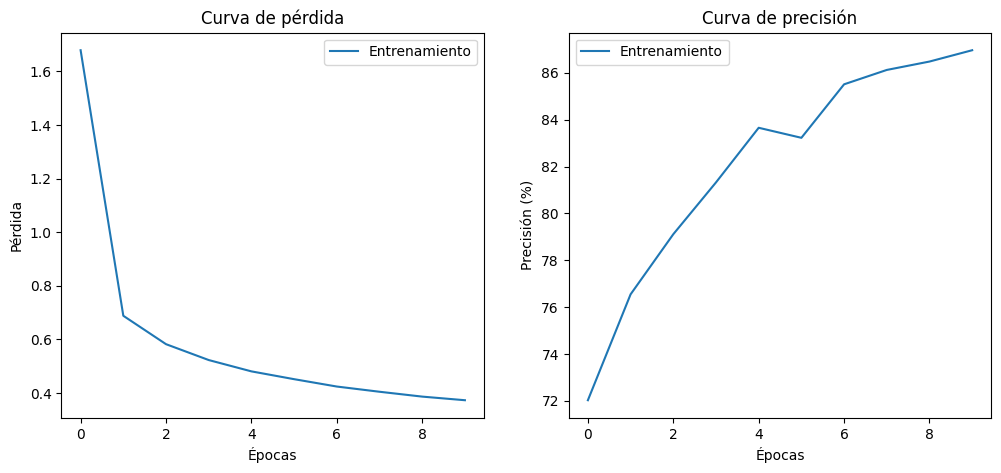

In [41]:
import matplotlib.pyplot as plt

# Curva de pérdida
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_perdida, label='Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de pérdida')
plt.legend()

# Curva de precisión
plt.subplot(1,2,2)
plt.plot(train_precision, label='Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.title('Curva de precisión')
plt.legend()

plt.show()